In [1]:
import random
import os
import re
import json
import pandas as pd
import lightgbm as lgbm
from datetime import datetime
from time import gmtime, strftime
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
import lightgbm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec
# from PIL import Image
# # from PIL import ImageFile
# # ImageFile.LOAD_TRUNCATED_IMAGES = True
# from transformers import ViltProcessor, ViltModel


random_seed = 2020
random.seed(random_seed)
np.random.seed(random_seed)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 读取数据
all_data = pd.read_csv('../data/feature_data_530.csv')
train_all_data = all_data[all_data['train_type'] != -1]
submit_all_data = all_data[all_data['train_type'] == -1]
# indexxx = pd.read_csv('../data/index.csv')
# train_all_data = train_all_data.iloc[indexxx['index']]
train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'label', 'mean_label']
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

print(len(train_feature_df), len(submit_feature_df))
print(len(train_label_df), len(submit_label_df))

305613 180581
305613 180581


In [3]:
train_all_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label
0,775,0,21894,4,8.690000,5,65,75,33,6,...,904,176,1446,4299.470263,1.531812,0.625173,2405,2729,1,11.18
1,1075,0,53866,13,7.525385,0,75,139,56,13,...,6200,679,75883,735.884072,0.052594,0.081705,8491,236,1,15.15
2,4890,0,26948,1,10.990000,3,42,480,12,2,...,2583,2,1039,5124.185756,2.820019,2.486044,1550,1346,1,10.99
3,6568,0,355,1,8.630000,10,68,225,18,3,...,76088,385,124017,148.035342,0.046018,0.613529,1233,1115,1,8.63
4,7079,0,315,31,8.489677,2,43,317,8,1,...,0,102,9218,5300.882729,0.579735,0.000000,5781,13,1,11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,1118328,2,8689,7,5.645714,4,7,194,9,1,...,0,0,0,0.000000,0.000000,0.000000,0,0,1,4.00
305609,1118334,2,7509,1,1.000000,6,48,282,4,1,...,411,32,284,1085.735915,2.313380,1.447183,122,39,1,1.00
305610,1118342,2,52220,3,2.826667,0,60,390,12,1,...,4939,202,1063,1340.824083,0.925682,4.646284,1234,988,1,2.00
305611,1118344,2,20298,112,10.689821,7,55,527,7,3,...,1291341,2882,12738,3800.696577,1.711336,101.377061,15549,18945,1,6.89


In [49]:
submit_all_data.info

<bound method DataFrame.info of             Pid  train_type    Uid  Uid_count  mean_label  Category  \
0         50731          -1  48249          1    0.000000         6   
1         96454          -1  58858         11    8.705455         3   
2        172136          -1  58858         11    8.705455         2   
3        177707          -1  27151        176    4.247443         3   
4        177708          -1  27151        176    4.247443         3   
...         ...         ...    ...        ...         ...       ...   
180576  1118324          -1  46088          2    4.380000         0   
180577  1118329          -1  12280          7    1.382857         0   
180578  1118336          -1  43496          9    3.674444         4   
180579  1118349          -1   5492         17    5.671176         7   
180580  1118356          -1  17523          4    0.000000         7   

        Subcategory  Concept  Title_len  Title_number  ...  totalFaves  \
0                13      352          8  

In [67]:
np.log1p(train_all_data['photo_count'] + 4).max()

14.907039149721848

In [ ]:
# 2978819,9098300

In [10]:
columns = ['Category', 'Uid', 'Subcategory', 'Longitude', 'Geoaccuracy',  
         'Title_len', 'Title_number','Alltags_len','Alltags_number', 
          'photo_count', 'totalTags', 'totalGeotagged', 'totalFaves',
          'totalInGroup','photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount',
          'followingCount', 'label']
train_sample1 = train_all_data[columns].sample(n = 50000)
train_sample2 = train_all_data[columns].sample(n = 50000)
## 计算两个分布之间的KS检验值
from scipy import stats
features_list = train_sample1.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(train_sample1[feature], train_sample2[feature])
    print("KS test value: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value: 0.003 with a p-value 0.97 for the feature Category
KS test value: 0.007 with a p-value 0.14 for the feature Uid
KS test value: 0.004 with a p-value 0.85 for the feature Subcategory
KS test value: 0.002 with a p-value 1.00 for the feature Longitude
KS test value: 0.004 with a p-value 0.81 for the feature Geoaccuracy
KS test value: 0.004 with a p-value 0.76 for the feature Title_len
KS test value: 0.004 with a p-value 0.79 for the feature Title_number
KS test value: 0.005 with a p-value 0.65 for the feature Alltags_len
KS test value: 0.005 with a p-value 0.61 for the feature Alltags_number
KS test value: 0.004 with a p-value 0.85 for the feature photo_count
KS test value: 0.004 with a p-value 0.84 for the feature totalTags
KS test value: 0.004 with a p-value 0.72 for the feature totalGeotagged
KS test value: 0.008 with a p-value 0.09 for the feature totalFaves
KS test value: 0.003 with a p-value 0.93 for the feature totalInGroup
KS test value: 0.003 with a p-value 0.95 for

In [11]:
columns = ['Category', 'Uid', 'Subcategory', 'Longitude', 'Geoaccuracy',  
         'Title_len', 'Title_number','Alltags_len','Alltags_number', 
          'photo_count', 'totalTags', 'totalGeotagged', 'totalFaves',
          'totalInGroup','photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount',
          'followingCount', 'label']
test_sample1 = submit_all_data[columns].sample(n = 50000)
test_sample2 = submit_all_data[columns].sample(n = 50000)
## 计算两个分布之间的KS检验值
from scipy import stats
features_list = test_sample1.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(test_sample1[feature], test_sample2[feature])
    print("KS test value: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value: 0.004 with a p-value 0.78 for the feature Category
KS test value: 0.007 with a p-value 0.20 for the feature Uid
KS test value: 0.003 with a p-value 1.00 for the feature Subcategory
KS test value: 0.002 with a p-value 1.00 for the feature Longitude
KS test value: 0.001 with a p-value 1.00 for the feature Geoaccuracy
KS test value: 0.004 with a p-value 0.90 for the feature Title_len
KS test value: 0.002 with a p-value 1.00 for the feature Title_number
KS test value: 0.004 with a p-value 0.81 for the feature Alltags_len
KS test value: 0.003 with a p-value 0.98 for the feature Alltags_number
KS test value: 0.003 with a p-value 0.92 for the feature photo_count
KS test value: 0.006 with a p-value 0.34 for the feature totalTags
KS test value: 0.003 with a p-value 0.95 for the feature totalGeotagged
KS test value: 0.006 with a p-value 0.37 for the feature totalFaves
KS test value: 0.007 with a p-value 0.17 for the feature totalInGroup
KS test value: 0.005 with a p-value 0.44 for

In [ ]:
all_data

In [12]:
from scipy import stats
features_list = test_sample1.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(train_sample1[feature], test_sample1[feature])
    print("KS test value: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value: 0.105 with a p-value 0.00 for the feature Category
KS test value: 0.020 with a p-value 0.00 for the feature Uid
KS test value: 0.047 with a p-value 0.00 for the feature Subcategory
KS test value: 0.010 with a p-value 0.02 for the feature Longitude
KS test value: 0.006 with a p-value 0.34 for the feature Geoaccuracy
KS test value: 0.129 with a p-value 0.00 for the feature Title_len
KS test value: 0.150 with a p-value 0.00 for the feature Title_number
KS test value: 0.257 with a p-value 0.00 for the feature Alltags_len
KS test value: 0.211 with a p-value 0.00 for the feature Alltags_number
KS test value: 0.039 with a p-value 0.00 for the feature photo_count
KS test value: 0.406 with a p-value 0.00 for the feature totalTags
KS test value: 0.020 with a p-value 0.00 for the feature totalGeotagged
KS test value: 0.445 with a p-value 0.00 for the feature totalFaves
KS test value: 0.455 with a p-value 0.00 for the feature totalInGroup
KS test value: 0.388 with a p-value 0.00 for

In [72]:
print(all_data['meanView'].min())
print(all_data['meanView'].max())

0.0
48702419.0


In [71]:
print(all_data['Alltags_len'].min())
print(all_data['Alltags_len'].max())

1
1680


In [6]:
train_all_data = all_data[all_data['train_type'] != -1]
submit_all_data = all_data[all_data['train_type'] == -1]
# indexxx = pd.read_csv('../data/index.csv')
# train_all_data = train_all_data.iloc[indexxx['index']]
train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'label', 'mean_label']
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

print(len(train_feature_df), len(submit_feature_df))
print(len(train_label_df), len(submit_label_df))

305613 180581
305613 180581


In [7]:
new_columns = ['Title_len', 'Title_number','Alltags_len','Alltags_number', 'totalTags', 'totalFaves','totalInGroup',
               'photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount','followingCount']
large_columns = ['totalTags', 'totalFaves','totalInGroup',
               'photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount','followingCount']
train_all_data = train_all_data.fillna(0)
submit_all_data = submit_all_data.fillna(0)
for index in large_columns:
    train_all_data[index] = np.log1p(train_all_data[index] + 4)
    submit_all_data[index] = np.log1p(submit_all_data[index] + 4)
for i in new_columns:
    # train_sample1[i] = train_sample1[i]
    print(i,' train_data_sample numda:',stats.boxcox_normmax(train_all_data[i]))
    print(i,' test_data_sample numda:',stats.boxcox_normmax(submit_all_data[i])) 
    # test_sample1[i] = test_sample1[i]
    # print(i,' test_sample numda:',stats.boxcox_normmax(test_sample1[i]))




Title_len  train_data_sample numda: 0.10266265250438829
Title_len  test_data_sample numda: 0.07440798219690141
Title_number  train_data_sample numda: -0.0575401263274232
Title_number  test_data_sample numda: -0.05223510382185718
Alltags_len  train_data_sample numda: 0.1382209815824436
Alltags_len  test_data_sample numda: 0.10131788587699564
Alltags_number  train_data_sample numda: 0.11784226800612985
Alltags_number  test_data_sample numda: 0.05093545763061938
totalTags  train_data_sample numda: 1.783363527801092
totalTags  test_data_sample numda: 1.7689575639312118
totalFaves  train_data_sample numda: 0.3010121732747632
totalFaves  test_data_sample numda: 0.3714411941878046
totalInGroup  train_data_sample numda: 0.26000383660325205
totalInGroup  test_data_sample numda: 0.30972682647800787
photoCount  train_data_sample numda: 1.869181868423653
photoCount  test_data_sample numda: 1.8204376119789742
meanView  train_data_sample numda: 1.172720043870982
meanView  test_data_sample numda: 1.2

In [8]:
from scipy import stats
# from scipy.stats import boxcox
train_all_data['Title_len'] = stats.boxcox(train_all_data['Title_len'], 0.10266265250438829)
train_all_data['Title_number'] = stats.boxcox(train_all_data['Title_number'], -0.0575401263274232)
train_all_data['Alltags_len'] = stats.boxcox(train_all_data['Alltags_len'], 0.1382209815824436)
train_all_data['Alltags_number'] = stats.boxcox(train_all_data['Alltags_number'], 0.11784226800612985)
train_all_data['totalTags'] = stats.boxcox(train_all_data['totalTags'], 1.783363527801092)
train_all_data['totalFaves'] = stats.boxcox(train_all_data['totalFaves'], 0.3010121732747632)
train_all_data['totalInGroup'] = stats.boxcox(train_all_data['totalInGroup'],0.26000383660325205)
train_all_data['photoCount'] = stats.boxcox(train_all_data['photoCount'], 1.869181868423653)
train_all_data['meanView'] = stats.boxcox(train_all_data['meanView'],1.172720043870982)
train_all_data['meanTags'] = stats.boxcox(train_all_data['meanTags'],-38.044161879942024 )
train_all_data['meanFaves'] = stats.boxcox(train_all_data['meanFaves'], -64.51642941558124)
train_all_data['followerCount'] = stats.boxcox(train_all_data['followerCount'], 0.8660132982311084)
train_all_data['followingCount'] = stats.boxcox(train_all_data['followingCount'], 0.5550597756029485)

In [9]:
submit_all_data['Title_len'] = stats.boxcox(submit_all_data['Title_len'], 0.07440798219690141)
submit_all_data['Title_number'] = stats.boxcox(submit_all_data['Title_number'], -0.05223510382185718)
submit_all_data['Alltags_len'] = stats.boxcox(submit_all_data['Alltags_len'], 0.10131788587699564)
submit_all_data['Alltags_number'] = stats.boxcox(submit_all_data['Alltags_number'], 0.05093545763061938)
submit_all_data['totalTags'] = stats.boxcox(submit_all_data['totalTags'], 1.7689575639312118)
submit_all_data['totalFaves'] = stats.boxcox(submit_all_data['totalFaves'], 0.3714411941878046)
submit_all_data['totalInGroup'] = stats.boxcox(submit_all_data['totalInGroup'],0.30972682647800787)
submit_all_data['photoCount'] = stats.boxcox(submit_all_data['photoCount'], 1.8204376119789742)
submit_all_data['meanView'] = stats.boxcox(submit_all_data['meanView'], 1.2946339619363967)
submit_all_data['meanTags'] = stats.boxcox(submit_all_data['meanTags'], -50.018984690156806)
submit_all_data['meanFaves'] = stats.boxcox(submit_all_data['meanFaves'], -63.047904913385196)
submit_all_data['followerCount'] = stats.boxcox(submit_all_data['followerCount'],  1.0042128649867634)
submit_all_data['followingCount'] = stats.boxcox(submit_all_data['followingCount'], 0.5648344382677112)

In [77]:
new_train_all_data = new_all_data[new_all_data['train_type'] != -1]
new_submit_all_data = new_all_data[new_all_data['train_type'] == -1]
# indexxx = pd.read_csv('../data/index.csv')
# train_all_data = train_all_data.iloc[indexxx['index']]
new_train_all_data = new_train_all_data.reset_index(drop=True)
new_submit_all_data = new_submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'label', 'mean_label']
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

new_train_label_df = new_train_all_data[['Pid', 'label']]
new_train_feature_df = new_train_all_data.drop(feature_columns, axis=1)

new_submit_label_df = new_submit_all_data[['Pid', 'label']]
new_submit_feature_df = new_submit_all_data.drop(feature_columns, axis=1)

print(len(new_train_feature_df), len(new_submit_feature_df))
print(len(new_train_label_df), len(new_submit_label_df))

305613 180581
305613 180581


In [39]:
train_sample1[(np.isnan(train_sample1['photo_count']) == False) & (np.isinf(train_sample1['photo_count']) == False)]

,Category,Uid,Subcategory,Longitude,Geoaccuracy,Title_len,Title_number,Alltags_len,Alltags_number,photo_count,...,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,label
156492,8,3793,26,0.0,0,4,1,241,27,26954,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,5.21
28385,10,18253,59,0.0,0,69,13,244,18,1509,...,12385,4,5,48108,116.387171,0.037333,0.000083,80,58,4.25
102267,6,43898,53,0.0,0,21,2,19,2,1990,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,4.00
159362,2,2062,43,0.0,0,13,2,152,19,2267,...,1,1,0,14167,458.363521,0.046022,0.000071,64,4,6.48
44006,0,41998,16,0.0,0,18,4,154,19,20274,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,5.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,7,16184,51,0.0,0,35,4,562,70,925,...,155,22,29,74693,489.664560,0.087652,0.000295,647,250,8.62
33533,8,26484,26,0.0,0,43,6,107,13,4848,...,1380,3952,400,5733,676.075877,0.816501,0.689342,1435,1601,6.83
33031,6,60056,53,0.0,0,8,1,120,17,2382,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,8.24
155588,10,56352,47,0.0,0,11,2,48,8,931,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,5.04


In [10]:
from scipy import stats
features_list = test_sample1.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(train_sample1[feature], test_sample1[feature])
    print("KS test value after log1p: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value after log1p: 0.105 with a p-value 0.00 for the feature Category
KS test value after log1p: 0.024 with a p-value 0.00 for the feature Uid
KS test value after log1p: 0.045 with a p-value 0.00 for the feature Subcategory
KS test value after log1p: 0.011 with a p-value 0.01 for the feature Longitude
KS test value after log1p: 0.008 with a p-value 0.06 for the feature Geoaccuracy
KS test value after log1p: 0.011 with a p-value 0.00 for the feature Title_len
KS test value after log1p: 0.008 with a p-value 0.05 for the feature Title_number
KS test value after log1p: 0.104 with a p-value 0.00 for the feature Alltags_len
KS test value after log1p: 0.086 with a p-value 0.00 for the feature Alltags_number
KS test value after log1p: 0.041 with a p-value 0.00 for the feature photo_count
KS test value after log1p: 0.033 with a p-value 0.00 for the feature totalTags
KS test value after log1p: 0.022 with a p-value 0.00 for the feature totalGeotagged
KS test value after log1p: 0.032 with 

In [11]:
train_sample1[new_columns] = train_sample1[new_columns].apply(lambda x: (x-x.mean())/x.std())
test_sample1[new_columns] = test_sample1[new_columns].apply(lambda x: (x-x.mean())/x.std())

In [12]:
from scipy import stats
features_list = test_sample1.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(train_sample1[feature], test_sample1[feature])
    print("KS test value after log1p and z-score: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value after log1p and z-score: 0.105 with a p-value 0.00 for the feature Category
KS test value after log1p and z-score: 0.024 with a p-value 0.00 for the feature Uid
KS test value after log1p and z-score: 0.045 with a p-value 0.00 for the feature Subcategory
KS test value after log1p and z-score: 0.011 with a p-value 0.01 for the feature Longitude
KS test value after log1p and z-score: 0.008 with a p-value 0.06 for the feature Geoaccuracy
KS test value after log1p and z-score: 0.130 with a p-value 0.00 for the feature Title_len
KS test value after log1p and z-score: 0.338 with a p-value 0.00 for the feature Title_number
KS test value after log1p and z-score: 0.021 with a p-value 0.00 for the feature Alltags_len
KS test value after log1p and z-score: 0.043 with a p-value 0.00 for the feature Alltags_number
KS test value after log1p and z-score: 0.017 with a p-value 0.00 for the feature photo_count
KS test value after log1p and z-score: 0.379 with a p-value 0.00 for the feature 

In [13]:
train_sample1

,Category,Uid,Subcategory,Longitude,Geoaccuracy,Title_len,Title_number,Alltags_len,Alltags_number,photo_count,...,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,label
171245,10,40201,47,0.0,0,0.162819,-1.025996,0.429270,0.760448,1.166111,...,1517,0.009988,1.376519,1.173466,0.998182,-0.465342,-0.357666,1.192075,0.637247,6.39
95727,0,4787,40,0.0,0,1.025786,1.244304,-0.289263,-0.632270,-0.012114,...,0,-0.881966,-0.900163,0.743177,-0.301654,-0.571094,-0.358430,-0.103115,-1.029135,4.86
155868,0,38245,40,0.0,0,-0.853292,-1.025996,-0.300545,-0.205722,0.028147,...,2,0.160287,-0.900163,0.584346,-0.051180,-0.565009,-0.341439,0.024677,0.179404,5.86
186782,5,12243,38,0.0,0,0.213353,0.632283,-0.690422,-0.765836,0.028546,...,0,0.599393,-0.137948,0.384817,0.861073,0.547122,-0.175589,0.575833,0.937078,4.09
14234,5,33876,9,0.0,0,-1.521501,-1.025996,0.157543,0.181412,0.525993,...,0,-0.881966,-0.900163,-1.231671,-1.190572,-0.576359,-0.358430,-1.133440,-1.029135,4.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77708,10,58629,56,0.0,0,0.950804,-1.025996,-1.911203,-1.793858,1.372658,...,0,-0.041182,-0.605298,0.471961,-0.116352,-0.517244,-0.345262,-0.251274,0.128625,4.81
194230,8,10224,26,0.0,0,0.552686,0.864962,-0.723107,-0.632270,0.974713,...,0,-0.881966,-0.900163,-0.224650,0.092323,-0.144901,-0.358430,-1.133440,-1.029135,2.00
96270,10,33533,67,0.0,0,-0.853292,-1.025996,0.618063,0.579038,0.543121,...,0,0.764520,0.855521,0.742608,0.217696,-0.481452,-0.285067,0.286010,0.527848,4.91
30361,2,17605,20,0.0,0,-1.775175,-1.025996,-0.245250,-0.632270,-4.025008,...,0,-0.881966,-0.900163,-1.231671,-1.190572,-0.576359,-0.358430,-1.133440,-1.029135,4.95


In [14]:
test_sample1

,Category,Uid,Subcategory,Longitude,Geoaccuracy,Title_len,Title_number,Alltags_len,Alltags_number,photo_count,...,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,label
141921,5,31629,15,0.0000,0,1.219861,1.252704,0.700742,0.437237,-0.509258,...,0,-0.850339,-0.870753,-1.165533,-1.122005,-0.569463,-0.350010,-1.087217,-0.978952,0.0
103993,0,39556,45,0.0000,0,1.344062,1.689106,1.734299,2.099322,0.186485,...,0,0.089294,-0.182605,0.846937,0.507638,-0.276510,-0.346369,-0.093044,0.391497,0.0
60144,10,3561,59,0.0000,0,1.740703,0.637630,-1.791368,-1.698060,0.133511,...,0,-0.850339,-0.870753,-1.165533,-1.122005,-0.569463,-0.350010,-1.087217,-0.978952,0.0
86376,4,15525,30,0.0000,0,0.565619,0.871470,1.020551,1.323270,1.292573,...,0,-0.850339,-0.870753,-1.165533,-1.122005,-0.569463,-0.350010,-1.087217,-0.978952,0.0
9509,5,6488,15,0.0000,0,-0.655749,-0.413846,-1.438776,-1.402007,1.674717,...,3,1.437004,0.287129,1.229239,0.472313,-0.494943,-0.268792,0.982222,0.616852,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74918,5,13688,14,0.0000,0,-1.848246,-1.028920,0.435466,0.679130,0.479122,...,0,-0.207810,-0.870753,0.868606,0.899782,-0.325321,-0.348948,0.656643,0.227213,0.0
66306,8,50513,46,-2.7192,15,0.639319,0.871470,0.058770,0.141185,-0.330520,...,20869,1.431178,1.419566,1.102382,1.067545,0.836803,-0.212470,0.998730,0.794523,0.0
26092,5,56132,38,0.0000,0,0.741890,0.871470,0.616938,0.733290,-0.286993,...,37169,0.815209,0.018355,-1.011964,-1.122005,-0.569463,6.496638,1.984580,1.495255,0.0
150489,1,56972,1,0.0000,0,-0.142586,-0.413846,-0.749703,-0.778437,-1.666027,...,0,-0.850339,-0.870753,-1.165533,-1.122005,-0.569463,-0.350010,-1.087217,-0.978952,0.0


In [15]:
## 可以得知，训练集分布比较一致，测试集比较一致，二者重合
## 尝试用optimal-transport来看看效果
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import os
from sklearn.metrics.pairwise import pairwise_distances

sns.set_style('white')
%matplotlib inline


In [16]:
train_all_data['Title_len'] submit_all_data['Title_len']

0         33
1         56
2         12
3         18
4          8
          ..
305608     9
305609     4
305610    12
305611     7
305612    21
Name: Title_len, Length: 305613, dtype: int64

In [12]:
"""
InfoOT solver
"""
# Author: Ching-Yao Chuang <cychuang@mit.edu>
# License: MIT License

import numpy as np
import scipy.io
import ot
from tqdm import tqdm
from sklearn.metrics import pairwise_distances


def dist(z1, z2, delta=5000):
    x1, x2 = z1[:-1], z2[:-1]
    y1, y2 = z1[-1], z2[-1]
    if y1 != y2:
        return np.linalg.norm(x1 - x2) + delta
    else:
        return np.linalg.norm(x1 - x2)

def ratio(P, Kx, Ky):
    '''
    compute the ratio berween joint and marginal densities
    Parameters
    ----------
    P : transportation plan
    Kx: source kernel matrix
    Ky: target kernel matrix
    Returns
    ----------
    ratio matrix for (x_i, y_j)
    '''
    import ot
    f_x = Kx.sum(1) / Kx.shape[1]
    f_y = Ky.sum(1) / Ky.shape[1]
    f_x_f_y = np.outer(f_x, f_y)
    constC = np.zeros((len(Kx), len(Ky)))
    f_xy = -ot.gromov.tensor_product(constC, Kx, Ky, P)
    return f_xy / f_x_f_y

def compute_kernel(Cx, Cy, h):
    '''
    compute Gaussian kernel matrices
    Parameters
    ----------
    Cx: source pairwise distance matrix
    Cy: target pairwise distance matrix
    h : bandwidth
    Returns
    ----------
    Kx: source kernel
    Ky: targer kernel
    '''
    std1 = np.sqrt((Cx**2).mean() / 2)
    std2 = np.sqrt((Cy**2).mean() / 2)
    h1 = h * std1
    h2 = h * std2
    # Gaussian kernel (without normalization)
    Kx = np.exp(-(Cx / h1)**2 / 2)
    Ky = np.exp(-(Cy / h2)**2 / 2)
    return Kx, Ky

def migrad(P, Kx, Ky):
    '''
    compute the gradient w.r.t. KDE mutual information
    Parameters
    ----------
    P : transportation plan
    Ks: source kernel matrix
    Kt: target kernel matrix
    Returns
    ----------
    negative gradient w.r.t. MI
    '''
    import ot
    f_x = Kx.sum(1) / Kx.shape[1]
    f_y = Ky.sum(1) / Ky.shape[1]
    f_x_f_y = np.outer(f_x, f_y)
    constC = np.zeros((len(Kx), len(Ky)))
    # there's a negative sign in ot.gromov.tensor_product
    f_xy = -ot.gromov.tensor_product(constC, Kx, Ky, P)
    P_f_xy = P / f_xy
    P_grad = -ot.gromov.tensor_product(constC, Kx, Ky, P_f_xy)
    P_grad = np.log(f_xy / f_x_f_y) + P_grad
    return -P_grad

def projection(P, X):
    '''
    compute the projection based on similarity matrix
    Parameters
    ----------
    P : transportation plan or similarity matrix
    X : target data
    Returns
    ----------
    projected source data
    '''
    weights = np.sum(P, axis = 1)
    X_proj = np.matmul(P, X) / weights[:, None]
    return X_proj

class FusedInfoOT():
    '''
    Solver for Fused InfoOT
    Parameters
    ----------
    Xs: source data
    Xt: target data 
    h : bandwidth
    Ys: source label
    lam: weight for mutual information
    reg: weight for entropic regularization
    '''
    def __init__(self, Xs, Xt, h, Ys=None, lam=100., reg=1.0):
        self.Xs = Xs
        self.Xt = Xt
        self.Ys = Ys
        self.h = h
        self.lam = lam
        self.reg = reg

        # init kernel
        self.C = pairwise_distances(Xs, Xt)
        if Ys is not None:
            Zs = np.concatenate((Xs, Ys.reshape(-1, 1)), axis=1)
            self.Cs = pairwise_distances(Zs, Zs, metric=dist)
        else:
            self.Cs = pairwise_distances(Xs, Xs)
        self.Ct = pairwise_distances(Xt, Xt)
        self.Ks, self.Kt = compute_kernel(self.Cs, self.Ct, h)
        self.P = None

    def solve(self, numIter=50, verbose='True'):
        '''
        solve projected gradient descent via sinkhorn iteration
        '''
        import ot
        p = np.zeros(len(self.Xs)) + 1. / len(self.Xs)
        q = np.zeros(len(self.Xt)) + 1. / len(self.Xt)
        P = np.outer(p, q)
        if verbose:
            print('solve projected gradient descent...')
            for i in tqdm(range(numIter)):
                grad_P = migrad(P, self.Ks, self.Kt)
                P = ot.bregman.sinkhorn(p, q, self.C + self.lam * grad_P, reg=self.reg)
        else:
            for i in range(numIter):
                grad_P = migrad(P, self.Ks, self.Kt)
                P = ot.bregman.sinkhorn(p, q, self.C + self.lam * grad_P, reg=self.reg)
        self.P = P
        return P

    def project(self, X, method='barycentric', h=None):
        if method not in ['conditional', 'barycentric']:
            raise Exception('only suppot conditional or barycebtric projection')
        if self.P is None:
            raise Exception('please run FusedInfoOT.solve() to obtain transportation plan')

        if h is None:
            h = self.h

        if np.array_equal(X, self.Xs):
            if method == 'conditional':
                if h == self.h:
                    P = ratio(self.P, self.Ks, self.Kt)
                else:
                    _Ks, _Kt = compute_kernel(self.Cs, self.Ct, h)
                    P = ratio(self.P, _Ks, _Kt)
            else:
                P = self.P
            return projection(P, self.Xt)
        else:
            if method == 'conditional':
                _Cs = pairwise_distances(X, Xs)
                _Ct = pairwise_distances(Xt, Xt)
                _Ks, _Kt = compute_kernel(_Cs, _Ct, h)

                P = ratio(P, _Ks, _Kt)
                return projection(P, self.Xt)
            else:
                raise Exception('barycentric cannot generalize to new samples')

    def conditional_score(self, X, h=None):
        if h is None:
            h = self.h
        _Cs = pairwise_distances(X, self.Xs)
        _Ct = pairwise_distances(self.Xt, self.Xt)
        _Ks, _Kt = compute_kernel(_Cs, _Ct, h)
        return ratio(self.P, _Ks, _Kt)


class InfoOT():
    '''
    Solver for InfoOT. Source and target can have different dimension.
    Parameters
    ----------
    Xs: source data
    Xt: target data
    h : bandwidth
    reg: weight for entropic regularization
    '''
    def __init__(self, Xs, Xt, h, reg=0.05):
        self.Xs = Xs
        self.Xt = Xt
        self.h = h
        self.reg = reg

        # init kernel
        self.Cs = pairwise_distances(Xs, Xs)
        self.Ct = pairwise_distances(Xt, Xt)
        self.Ks, self.Kt = compute_kernel(self.Cs, self.Ct, h)
        self.P = None

    def solve(self, numIter=100, verbose='True'):
        '''
        solve projected gradient descent via sinkhorn iteration
        '''
        import ot
        p = np.zeros(len(self.Xs)) + 1. / len(self.Xs)
        q = np.zeros(len(self.Xt)) + 1. / len(self.Xt)
        P = np.outer(p, q)
        if verbose:
            print('solve projected gradient descent...')
            for i in tqdm(range(numIter)):
                grad_P = migrad(P, self.Ks, self.Kt)
                P = ot.bregman.sinkhorn(p, q, grad_P, reg=self.reg)
        else:
            for i in range(numIter):
                grad_P = migrad(P, self.Ks, self.Kt)
                P = ot.bregman.sinkhorn(p, q, grad_P, reg=self.reg)
        self.P = P
        return P

    def project(self, X, method='barycentric', h=None):
        if method not in ['conditional', 'barycentric']:
            raise Exception('only suppot conditional or barycebtric projection')
        if self.P is None:
            raise Exception('please run InfoOT.solve() to obtain transportation plan')

        if h is None:
            h = self.h

        if np.array_equal(X, self.Xs):
            if method == 'conditional':
                if h == self.h:
                    P = ratio(self.P, self.Ks, self.Kt)
                else:
                    _Ks, _Kt = compute_kernel(self.Cs, self.Ct, h)
                    P = ratio(self.P, _Ks, _Kt)
            else:
                P = self.P
            return projection(P, self.Xt)
        else:
            if method == 'conditional':
                _Cs = pairwise_distances(X, Xs)
                _Ct = pairwise_distances(Xt, Xt)
                _Ks, _Kt = compute_kernel(_Cs, _Ct, h)

                P = ratio(P, _Ks, _Kt)
                return projection(P, self.Xt)
            else:
                raise Exception('barycentric cannot generalize to new samples')

    def conditional_score(self, X, h=None):
        if h is None:
            h = self.h
        _Cs = pairwise_distances(X, self.Xs)
        _Ct = pairwise_distances(self.Xt, self.Xt)
        _Ks, _Kt = compute_kernel(_Cs, _Ct, h)
        return ratio(self.P, _Ks, _Kt)

In [15]:
import numpy as np
import scipy.io
import ot
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

train_sample = train_all_data[columns].sample(n = 500)
test_sample = submit_all_data[columns].sample(n = 500)
train_sample = train_sample + 1
test_sample = test_sample + 1
ot = FusedInfoOT(train_sample, test_sample, h=0.5, reg=1.)
P = ot.solve()

solve projected gradient descent...


  0%|                                                                                                                                         | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/ot/bregman.py:502: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/usr/local/lib/python3.8/dist-packages/ot/bregman.py:502: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/usr/local/lib/python3.8/dist-packages/ot/backend.py:1037: RuntimeWarning: overflow encountered in exp
  return np.exp(a)
/usr/local/lib/python3.8/dist-packages/ot/bregman.py:495: RuntimeWarning: overflow encountered in multiply
  Kp = (1 / a).reshape(-1, 1) * K
/tmp/ipykernel_16682/469957704.py:83: RuntimeWarning: invalid value encountered in divide
  P_f_xy = P / f_xy
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.45it/s]


In [16]:
P

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [17]:
train_all_data['type'] = 0
submit_all_data['type'] = 1
all_data_type = pd.concat([train_all_data, submit_all_data])
all_data_type

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,type
0,775,0,21894,4,8.690000,5,65,75,33,6,...,176,1446,4299.470263,1.531812,0.625173,2405,2729,1,11.18,0
1,1075,0,53866,13,7.525385,0,75,139,56,13,...,679,75883,735.884072,0.052594,0.081705,8491,236,1,15.15,0
2,4890,0,26948,1,10.990000,3,42,480,12,2,...,2,1039,5124.185756,2.820019,2.486044,1550,1346,1,10.99,0
3,6568,0,355,1,8.630000,10,68,225,18,3,...,385,124017,148.035342,0.046018,0.613529,1233,1115,1,8.63,0
4,7079,0,315,31,8.489677,2,43,317,8,1,...,102,9218,5300.882729,0.579735,0.000000,5781,13,1,11.16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180576,1118324,-1,46088,2,4.380000,0,35,301,6,1,...,84,347,833.933718,2.844380,12.510086,489,612,1,0.00,1
180577,1118329,-1,12280,7,1.382857,0,60,110,25,4,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.00,1
180578,1118336,-1,43496,9,3.674444,4,28,186,41,7,...,98,6556,1611.040268,3.334503,0.796980,702,113,1,0.00,1
180579,1118349,-1,5492,17,5.671176,7,27,54,15,3,...,373,2138,2480.537418,2.655285,11.543031,1092,389,1,0.00,1


In [21]:
all_data['Pathalias']

KeyError: 'Pathalias'

In [ ]:
all_data_type['']

In [ ]:
## 对train和test进行可视化
# xtot=np.concatenate((xs,xt),axis=0) # all data

xp=TSNE().fit_transform(all_data_type) # this maigh take a while (30 sec on my laptop)

# separate again but now in 2D
xps=xp[:305613,:] 
xpt=xp[305613:,:]
pl.figure(3,(12,10))

pl.scatter(xps[:,0],xps[:,1],c=ys,marker='o',cmap='tab10',label='Source data')
pl.scatter(xpt[:,0],xpt[:,1],c=yt,marker='+',cmap='tab10',label='Target data')
pl.legend()
pl.colorbar()
pl.title('TSNE Embedding of the Source/Target data');

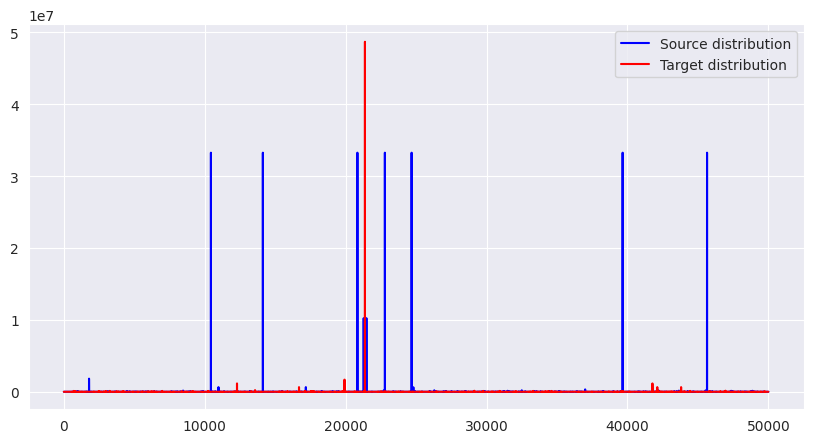

In [7]:
train_meanView = train_all_data['meanView']
test_meanView = submit_all_data['meanView']
plt.figure(1, figsize=(10, 5))
train_meanView = train_meanView.sample(n = 50000)
test_meanView = test_meanView.sample(n = 50000)
number = np.arange(len(train_meanView))
plt.plot(number, train_meanView, 'b', label='Source distribution')
plt.plot(number, test_meanView, 'r', label='Target distribution')
plt.legend()

In [9]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
# cost matrix
cost_matrix = ot.dist(number.reshape((50000, 1)), number.reshape((50000, 1)))
cost_matrix = cost_matrix / cost_matrix.max()

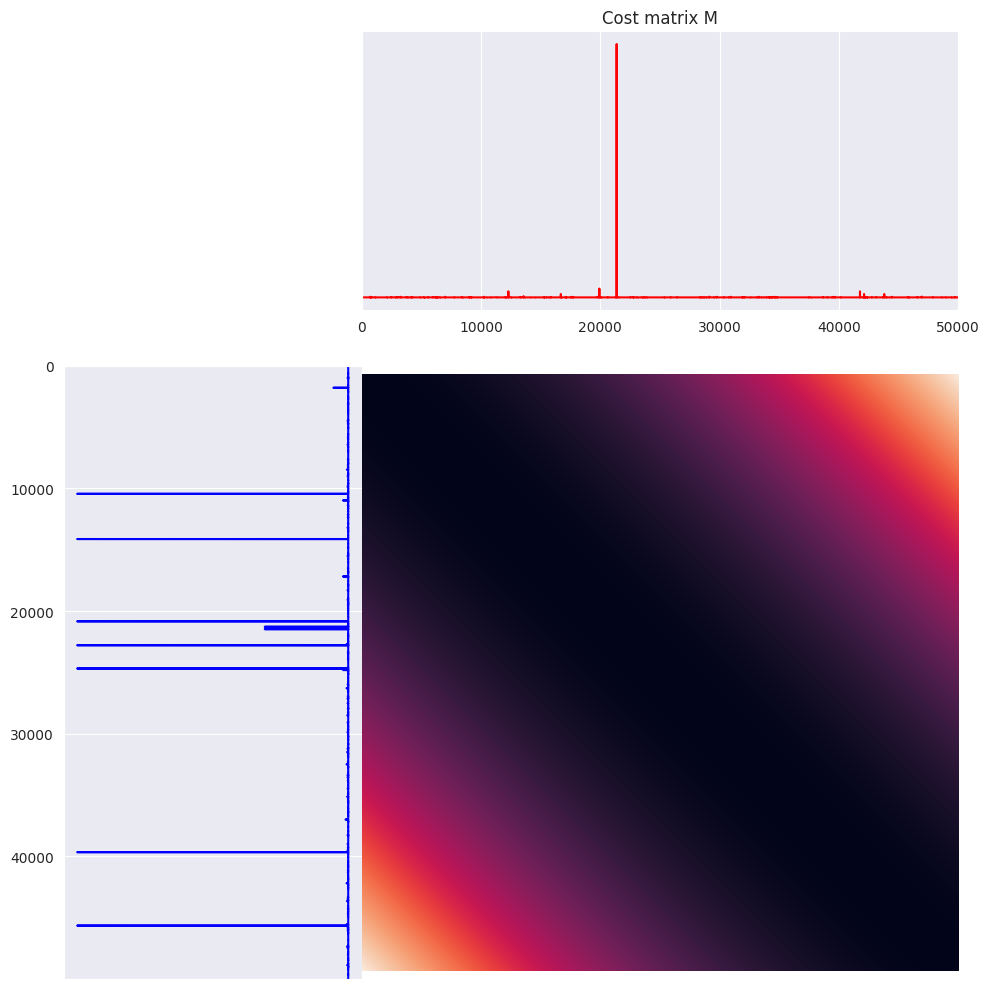

In [10]:
plt.figure(2, figsize=(10, 10))
ot.plot.plot1D_mat(train_meanView, test_meanView, cost_matrix, 'Cost matrix M')

In [12]:
T = ot.emd(np.array(train_meanView), np.array(test_meanView), cost_matrix)

AssertionError: 
Arrays are not almost equal to 7 decimals a and b vector must have the same sum
 ACTUAL: 325523149.6918913
 DESIRED: 84687410.50539915

In [ ]:
plt.figure(3, figsize=(10, 10))
ot.plot.plot1D_mat(train_meanView, test_meanView, T, 'Transportation Plan')

In [17]:
train_meanView = train_meanView + 1
test_meanView = test_meanView + 1

In [18]:
### Solve using Sinkhorn algorithm
reg = 1e-3 # regularization term
nit = 200  # default number of iterations

#  verbose = True outputs the loss value of the algorithm
Gs = ot.sinkhorn(np.array(train_meanView), np.array(test_meanView), cost_matrix, reg=reg, numItermax=nit, verbose=True)

It.  |Err         
-------------------
    0|4.830799e+07|
   10|6.842950e+07|
   20|8.435330e+07|
   30|8.886578e+07|
   40|9.183300e+07|
   50|9.488997e+07|
   60|9.722551e+07|
   70|9.905214e+07|
   80|1.005969e+08|
   90|1.019795e+08|
  100|1.032587e+08|
  110|1.044653e+08|
  120|1.056167e+08|
  130|1.067259e+08|
  140|1.078245e+08|
  150|1.089867e+08|
  160|1.103049e+08|
  170|1.118533e+08|
  180|1.142226e+08|
  190|1.222230e+08|


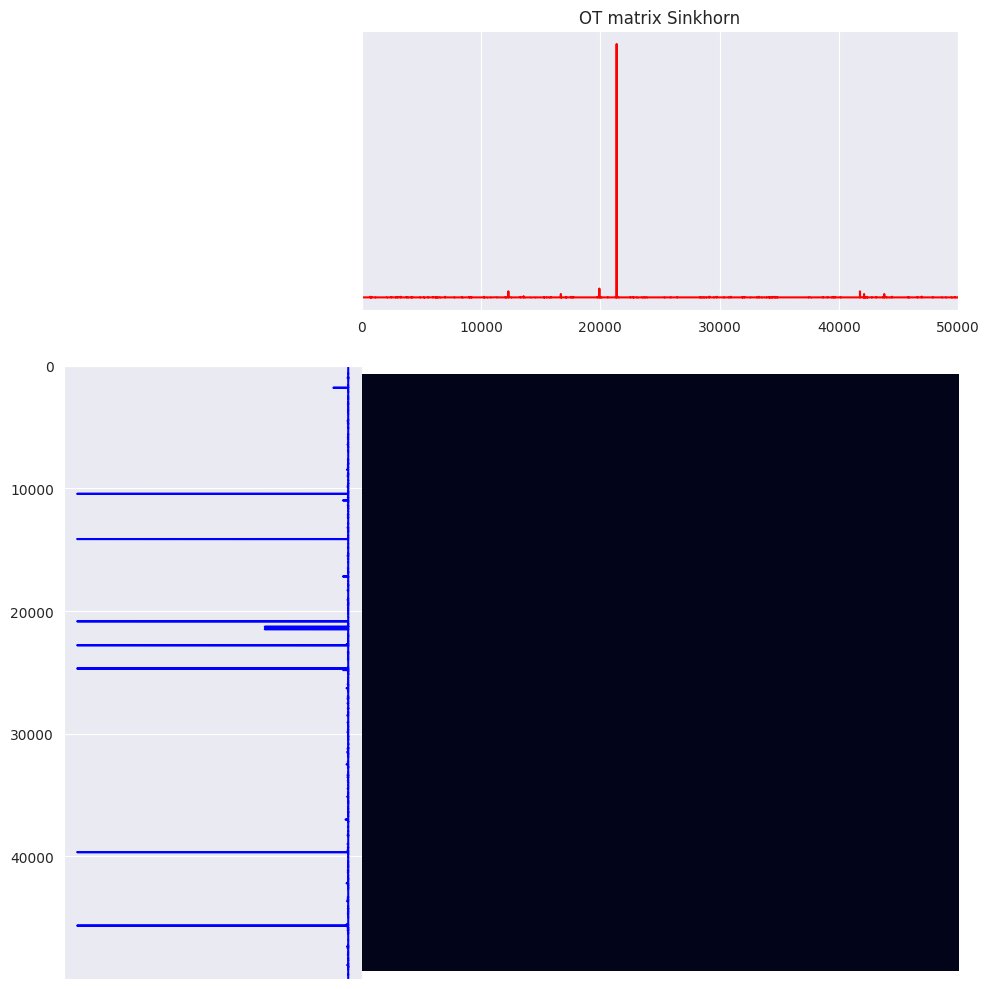

In [19]:
plt.figure(4, figsize=(10, 10))
ot.plot.plot1D_mat(train_meanView, test_meanView, Gs, 'OT matrix Sinkhorn')
plt.show()

In [16]:
np.abs(np.sum(T*cost_matrix) - ot.emd2(train_meanView, test_meanView, cost_matrix))

NameError: name 'T' is not defined

In [ ]:
# import numpy as np
# import scipy
# import argparse

# from infoot import FusedInfoOT

# def get_acc(score, Y1_test, Y2):
#     idx = np.argsort(-score, axis = 1)
#     idx_1 = idx[:, :1]
#     idx_5 = idx[:, :5]
#     idx_15 = idx[:, :15]
#     acc_1, acc_5, acc_15 = 0., 0., 0.
#     for i in range(len(X1_test)):
#         pred_1 = Y2[idx_1[i]]
#         pred_5 = Y2[idx_5[i]] 
#         pred_15 = Y2[idx_15[i]]
#         acc_1 += float(pred_1 == Y1_test[i])
#         acc_5 += (pred_5 == Y1_test[i]).mean()
#         acc_15 += (pred_15 == Y1_test[i]).mean()
#     acc_1 = acc_1 / len(X1_test)
#     acc_5 = acc_5 / len(X1_test)
#     acc_15 = acc_15 / len(X1_test)
#     print('P@1: {}'.format(acc_1))
#     print('P@5: {}'.format(acc_5))
#     print('P@15: {}'.format(acc_15))
#     return acc_1, acc_5, acc_15


# parser = argparse.ArgumentParser(description='Domain Adaptation')
# parser.add_argument('--src', default='caltech', type=str, help='source dataset name')
# parser.add_argument('--tgt', default='dslr', type=str, help='target dataset name')
# parser.add_argument('--rs', default=0, type=int, help='random seed')

# args = parser.parse_args()
# np.random.seed(args.rs)

# # load data
# mat1 = scipy.io.loadmat('decaf6/'+args.src+'_decaf.mat')
# mat2 = scipy.io.loadmat('decaf6/'+args.tgt+'_decaf.mat')

# X1 = mat1['feas']
# Y1 = mat1['labels'].reshape(-1)
# X2 = mat2['feas']
# Y2 = mat2['labels'].reshape(-1)

# idx = np.array(range(len(X1)))
# np.random.shuffle(idx)
# X1, Y1 = X1[idx], Y1[idx]

# X1_train = X1[:int(len(X1)*0.9)]
# Y1_train = Y1[:int(len(X1)*0.9)]
# X1_test = X1[int(len(X1)*0.9):]
# Y1_test = Y1[int(len(X1)*0.9):]

# ot = FusedInfoOT(X1_train, X2, h=0.5, reg=5.)
# ot.solve()

# acc_1, acc_5, acc_15 = get_acc(ot.conditional_score(X1_test), Y1_test, Y2)